# MNIST Tensorflow 2
This is an example of building a multi-layer network in Tensorflow 2 to solve the MNIST problem.
The objective is to be low-level enough to understand the operation on a layer-by-layer,
matrix operation level.

In [1]:
! date

Thu Jun 18 10:36:22 EDT 2020


In [2]:
import sys;
print( "Runnning python version %s.\n" % sys.version );

Runnning python version 3.5.2 (default, Apr 16 2020, 17:47:17) 
[GCC 5.4.0 20160609].



In [3]:
import nvgpu;
import tensorflow as tf;
print( "Running tensorflow version %s.\n" % (tf.__version__,) );

# this prints out which CPU/GPU is being used
tf.debugging.set_log_device_placement(True);






Running tensorflow version 2.2.0.



In [4]:
import time;
import numpy as np;

In [5]:
import pynvml as nv;
nv.nvmlInit();
GPU_NO = nv.nvmlDeviceGetCount();
handles = [nv.nvmlDeviceGetHandleByIndex(i) for i in range(GPU_NO)];
def gpu_utilization():
    return [nv.nvmlDeviceGetUtilizationRates(handle).gpu for handle in handles];

In [6]:
# the only place where I want to use Keras
mnist = tf.keras.datasets.fashion_mnist;

(x_train, y_train), (x_test, y_test) = mnist.load_data();

In [7]:
# show the shapes of the data
print( x_train.shape );
print( y_train.shape );
print( x_test.shape );
print( y_test.shape );

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [8]:




##########################################################################

# some short-cut names

EPS = np.finfo(np.double).eps

 

sigmoid = tf.nn.sigmoid;
softmax = tf.nn.softmax;

vs_init = tf.initializers.GlorotUniform();
zeros_init = tf.zeros;

##########################################################################



##########################################################################

class Layer: 
    """
    This respresents a layer in a neural network.
    
    It's attributes are:
        name     - a name given to the Layer,
        node_no  - the number of nodes in the Layer,
        transfer - the transfer function used by the nodes in the Layer,
        inputs   - a WeightLayer that provides inputs to this Layer,
        outputs  - a WeightLayer that receives the outputs of this Layer,
        biases   - a tf.Variable that holds the output bias values for 
                   this Layer.
    """
    
    def __init__( self, PARAMETERS, name, node_no, transfer ):
        """
        Constructor function that sets object attributes to match
        arguments, sets the outputs attribute to None, and initalizes
        the biases.
        """
        self.params   = PARAMETERS;
        self.name     = name;
        self.node_no  = node_no;
        self.transfer = transfer;
        self.inputs   = None;
        self.outputs  = None;
        self.biases   = tf.Variable( 
                              self.params['BIAS_INIT']( [ self.node_no ], dtype=DTYPE ),             
                              name='B_%s' % (self.name,),
                              trainable=True ); 

    def __rshift__( self, other ):
        """
        This overloads the right shift operator (>>) to allow users
        to create a network by connecting two Layers together.
        """
        return NN(self,other);
    
    @tf.function
    def output( self, input ):
        """
        Create decorated function to compute the activation values
        of the neurons in this Layer.
        
        input is the input to the entire NN.
        
        This is the main operation of a Layer.  It adds the output
        values to the net values, and applies a transfer function.
        """
        return self.transfer( tf.nn.bias_add( 
                                    self.inputs.output(input), 
                                    self.biases ) );

    # @tf.function
    # This function cannot be decorated because it won't work with the tape
    def update( self, loss, tape ):
        gradient = tape.gradient( loss, self.biases );
        self.biases.assign( self.biases - \
                            self.params['LEARNING_RATE']*gradient);


##########################################################################
    
class InputLayer(Layer):
    """
    Special Class of Layer that is an input layer.
    
    It's transfer, inputs, init, and outputs attributes are all undefined.
    
    It overrides the __init__ and output functions.
    It inherits __rshift__ from Layer. 
    """
    def __init__( self, PARAMETERS, name, node_no ):
        """
        Constructor function that sets object attributes to match
        arguments.
        """
        self.params   = PARAMETERS;
        self.name     = name;
        self.node_no  = node_no;
        
    @tf.function
    def output( self, inputs ):
        """
        Create decorated function to compute the activation values
        of the neurons in this InputLayer.
        
        It just returns the passed inputs value.
        """
        return inputs;

    # @tf.function
    # This function cannot be decorated because it won't work with the tape
    def update( self, loss, tape ):
        pass;


##########################################################################


class WeightLayer:
    """
    This class represents a layer of weights between two Layers of 
    neurons.
    
    It has the following attributes:
        src     - a Layer or InputLayer of neurons that passes activation
                  values through the WeightLayer,
        name    - a name given to the WeightLayer,
        init    - initialization function to set weight values,
        dest    - a Layer or InputLayer of neurons that receives a signal
                  from the WeightLayer.
        weights - a tf.Variable that holds the weight values for 
                this WeightLayer.
    """
    
    def __init__( self, PARAMETERS, src, dest ):
        """
        Constructor function that sets object attributes to match
        arguments.
        
        It also sets the name based on the src.name and dest.name
        and initializes weights.
        """
        self.params  = PARAMETERS;
        self.src     = src;
        # make init a function that will randomize weights
        self.name    = "W_%s_%s" % (src.name,dest.name);
        
        self.dest    = dest;
        self.weights = tf.Variable( 
                           self.params['WEIGHT_INIT']( [ src.node_no, 
                                                         dest.node_no ], 
                                        dtype=DTYPE ), 
                           name=self.name,
                              trainable=True  );
        
        self.src.outputs = self;
        self.dest.inputs = self;
        
    @tf.function
    def output( self, inputs ):
        """
        Create decorated function to compute the net values
        passed to the dest Layer.
        
        This is the main operation of a WeightLayer, it performs
        a matrix multiplication of the src Layer activations 
        (pattern-wise) by the weights.
        """
        return tf.matmul( self.src.output(inputs), self.weights );
    
    # @tf.function
    # This function cannot be decorated because it won't work with the tape
    def update( self, loss, tape ):
        gradient = tape.gradient( loss, self.weights );
        self.weights.assign(self.weights - 
                            self.params['LEARNING_RATE']*gradient);
        

##########################################################################


class NN:
    """
    This class respresents a Neural Networks.
    
    The NNs attributes are:
        layers       - an list of layers in the network from input to output,
        input_layer  - a reference to layers[0] --- the input layer,
        output_layer - a reference to layers[-1] --- the output layer,
        loss_fn      - loss function.
    """
    
    def __init__( self, l0, l1 ):
        """
        Construct a network with an input layer, l0, and one more 
        layer, l1.
        """
        # make init a function that will randomize weights
        self.params       = l0.params;
        self.layers       = [ l0, l1 ];
        self.input_layer  = self.layers[0];
        self.weights      = [ WeightLayer(self.params,l0,l1) ];
        self.output_layer = self.layers[-1];
        self.loss_fn      = None;
        
    def __rshift__( self, other ):
        """
        Add a Layer to the network.
        """
        if isinstance(other,Layer):
            self.layers.append( other );
            self.weights.append( WeightLayer(self.params,self.layers[-2],other) );
            self.output_layer = self.layers[-1];
        
            return self;
        
        
        if isinstance(other,tf.python.eager.def_function.Function):
            # assume its a loss function
            self.loss_fn = other;
            
            return self;
            
        else:
            print( type(other) );

    @tf.function
    def output( self, inputs ):
        """
        Create decorated function to compute the output values
        generated by the NN for a given input.
        """
        return self.output_layer.output( inputs );
            
    @tf.function
    def loss( self, target, inputs ):
        """
        Apply the loss function to comp ute the loss.
        """
        return self.loss_fn( target, self.output( inputs ) );
    
    @tf.function
    def train( self, target, inputs ):
        """
        Propagate the inputs through the network and
        update the weights and layers (biases) based on
        the target values.
        """
        # compute the loss and its gradient
        with tf.GradientTape(persistent=True) as tape:
            loss = self.loss(target, inputs);
            
        # udpate the weights based on the loss and gradient
        for weight in self.weights:
            weight.update( loss, tape );
            
        # udpate the layers (biases) based on the loss and gradient
        for layer in self.layers:
            layer.update( loss, tape );
        del( tape );
            

            
    #@tf.function
    def train_epochs( self, y_train, x_train, y_test, x_test ):
        """
        Perform multiple epochs of training based on global parameter
        values.
        """
        # create numpy arrays to store data
        logs = {
            "losses"        : np.zeros( (self.params['MAX_EPOCHS']+1,self.params['MINI_BATCH']), \
                                        dtype=np.float32 ),
            "corrects"      : np.zeros( (self.params['MAX_EPOCHS']+1,self.params['MINI_BATCH']), \
                                        dtype=np.int32 ),
            "test_losses"   : np.zeros( (self.params['MAX_EPOCHS']+1,), \
                                        dtype=np.float32 ),
            "test_corrects" : np.zeros( (self.params['MAX_EPOCHS']+1,), \
                                        dtype=np.int32 ),
            "utilization"   : np.zeros( (self.params['MAX_EPOCHS']+1,GPU_NO), \
                                        dtype=np.float32 ),
        };

        MB_SIZE = self.params['TRAINING_SIZE']//self.params['MINI_BATCH'];
       
        before = time.time();
        for epoch in range(0,self.params['MAX_EPOCHS']+1):
            logs['test_losses'][epoch] = nn.loss( one_hot(y_test), preprocess(x_test) );
            test_conf = confusion(y_test,x_test);
            logs['test_corrects'][epoch] = tf.linalg.trace( test_conf );


            x,y = double_shuffle( x_train, y_train );
            for mini_batch in range(0,self.params['MINI_BATCH']):

                mbx = x[(MB_SIZE*mini_batch):(MB_SIZE*(mini_batch+1))];
                mby = y[MB_SIZE*mini_batch:MB_SIZE*(mini_batch+1)];
                logs['losses'][epoch][mini_batch] = nn.loss( one_hot(mby), 
                                                     preprocess(mbx) );
        
                conf = confusion( mby, mbx );
                            
                logs['corrects'][epoch][mini_batch] = tf.linalg.trace( conf );

                self.train( one_hot(mby), preprocess(mbx) );
   
            logs['utilization'][epoch] = gpu_utilization();
            sys.stdout.write( "%d," % (epoch,) ); 
        after = time.time();
        sys.stdout.write( "\n" );
        logs['test_conf'] = test_conf;
        logs['total_time'] = after-before;
        
        return logs;

##########################################################################
# helper functions

@tf.function
def preprocess(input):
    """
    This decorated function converts the 28x28 pixel images
    into 784 dimensional feature vectors.  It also converts
    the uint8 into DTYPE.
    """
    return tf.reshape( tf.cast(input,DTYPE),
                ( input.shape[0], input.shape[1]*input.shape[2])
              )/256.0;

@tf.function
def one_hot( y_train ):
    return tf.one_hot( y_train, 10 );

@tf.function
def loss( y_target, y_pred ):
    return -tf.reduce_mean( y_target * tf.math.log(y_pred + EPS) + \
                            (1 - y_target) * tf.math.log(1 - y_pred + EPS) );

@tf.function
def un_hot( inputs ):
    return tf.math.argmax(inputs,1);

#@tf.function
def confusion(targets,inputs):
    return tf.math.confusion_matrix( 
        targets, 
        un_hot( nn.output( preprocess( inputs ) ) ) );

# do not decorate this one
#@tf.function
def double_shuffle(inputs,targets):
    if inputs.shape[0]!=targets.shape[0]:
        raise Exception("Dimenionality missmatch!");
    shuffle = tf.random.shuffle( tf.range(inputs.shape[0]) );
    
    shuffled_inputs = tf.gather(inputs,shuffle);
    shuffled_targets = tf.gather(targets,shuffle);

    return shuffled_inputs.numpy(), shuffled_targets.numpy();
    

In [9]:
"""
Test the double_shuffle function.

Shuffle the data, then print out 10 numbers from the unshuffled data and the shuffled data
to show that the labels match the images and the suffled numbers are shuffled.
"""
x2,y2 = double_shuffle(x_train,y_train);

import matplotlib.pyplot as plt

def show10(x_train,y_train):
    fig, axs = plt.subplots(1,10,figsize=(15,16));

    for idx in range(10):
        axs[idx].imshow( x_train[idx], cmap='Greys', interpolation='nearest');
        axs[idx].set( title="\""+str(y_train[idx])+"\"" );
    fig.tight_layout(pad=2.0);
    plt.show();

print( "unshuffled" );
show10(x_train,y_train);

print( "shuffled" );
show10(x2,y2);

Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomShuffle in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:CPU:0
unshuffled


<Figure size 1500x1600 with 10 Axes>

shuffled


<Figure size 1500x1600 with 10 Axes>

In [10]:
def show_results( params, logs ):
    MB_SIZE = params['TRAINING_SIZE']//params['MINI_BATCH'];
    
    fig, axs = plt.subplots(7,figsize=(15,45));

    epochs = range(0,params['MAX_EPOCHS']+1);
    batches = range(0,(params['MAX_EPOCHS']+1)*params['MINI_BATCH']);

    losses_per_batch = np.reshape( logs["losses"], [(params['MAX_EPOCHS']+1)*params['MINI_BATCH']] );

    l, = axs[0].plot( batches, losses_per_batch );
    axs[0].set(xlabel=r'batch', ylabel=r'loss',
           title='Loss', ylim=(0,0.45)  );
    axs[0].grid();

    l, = axs[1].plot( epochs, np.mean( logs["losses"], 1 ) );
    axs[1].set(xlabel=r'epoch', ylabel=r'loss',
           title='Average Loss', ylim=(0,0.45)  );
    axs[1].grid();

    corrects_per_batch = np.reshape( logs["corrects"], [(params['MAX_EPOCHS']+1)*params['MINI_BATCH']] );

    l, = axs[2].plot( batches, corrects_per_batch );
    axs[2].set(xlabel=r'batch', ylabel=r'correct',
           title='Correct', ylim=(0,MB_SIZE) );
    axs[2].grid();

    l, = axs[3].plot( epochs, np.sum( logs["corrects"], 1 ) );
    axs[3].set(xlabel=r'epoch', ylabel=r'correct',
           title='Total Correct', ylim=(0,params['TRAINING_SIZE']) );
    axs[3].grid();

    l, = axs[4].plot( epochs, logs["test_losses"] );
    axs[4].set(xlabel=r'epochs', ylabel=r'loss',
           title='Test Loss', ylim=(0,0.45));
    axs[4].grid();

    l, = axs[5].plot( epochs, logs["test_corrects"] );
    axs[5].set(xlabel=r'epoch', ylabel=r'correct',
           title='Test Correct', ylim=(0,params['TEST_SIZE']) );
    axs[5].grid();

    l = {};
    for gpu in range( GPU_NO ):
        l[gpu], = axs[6].plot( epochs, logs["utilization"][:,gpu] );
    axs[6].set(xlabel=r'epoch', ylabel=r'utlization',
           title='GPU Utilization', ylim=(0,100) );
    axs[6].legend( tuple([l[gpu] for gpu in range(GPU_NO)]),
            tuple(range(GPU_NO)) );
    axs[6].grid();

    fig.tight_layout(pad=2.0);
    plt.show();

    print( "Confusion matrix of test data:" );
    print( logs["test_conf"] );
    print();
    print( "Total time: %s" % (logs["total_time"],) );
    print( "Epochs/s: %s" % (params['MAX_EPOCHS']/logs["total_time"],) );
    print( "Updates/s: %s" % (params['MAX_EPOCHS']*params['MINI_BATCH']/logs["total_time"],) );
    
    print( "Training Examples/Update: %s" % (MB_SIZE,) );


## Network 1:  Run-time 150s

In [11]:
# Mini-batch learning
##########################################################################
# This updates the weights after presentation a mini-batch training
# data.  The size of the minibatch is 1/1000 of the entire training data
# in this case 60 examples.
# It requires few epochs, but runs inefficiently on the GPU.
##########################################################################
##########################################################################
# Parameters

DTYPE = tf.float32;

PARAMETERS1 = {
    

    'WEIGHT_INIT' : vs_init,
    'BIAS_INIT' : zeros_init,
    
    'LEARNING_RATE' : 0.2,


    'MAX_EPOCHS' : 25,     # maximum number of epochs to run
    'TRAINING_SIZE' : x_train.shape[0], # number of training examples
    'TEST_SIZE' : x_test.shape[0], # number of testing examples


    # use this for mini-batch learning
    'MINI_BATCH' : 1000,   # number of mini_batches per epoch

    # use this for iteration learning
    #'MINI_BATCH' : x_train.shape[0],

    # use this for epoch learning
    #'MINI_BATCH' : 1,


};


##########################################################################
##########################################################################


    
# build the network
    
input_l  = InputLayer( PARAMETERS1, "input", 28*28 );
hidden_l = Layer( PARAMETERS1, "hidden", 28*28, sigmoid );
output_l = Layer( PARAMETERS1, "output", 10, softmax );

nn = input_l >> hidden_l >> output_l >> loss;

# train it

logs1 = nn.train_epochs( y_train, x_train, y_test, x_test );

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

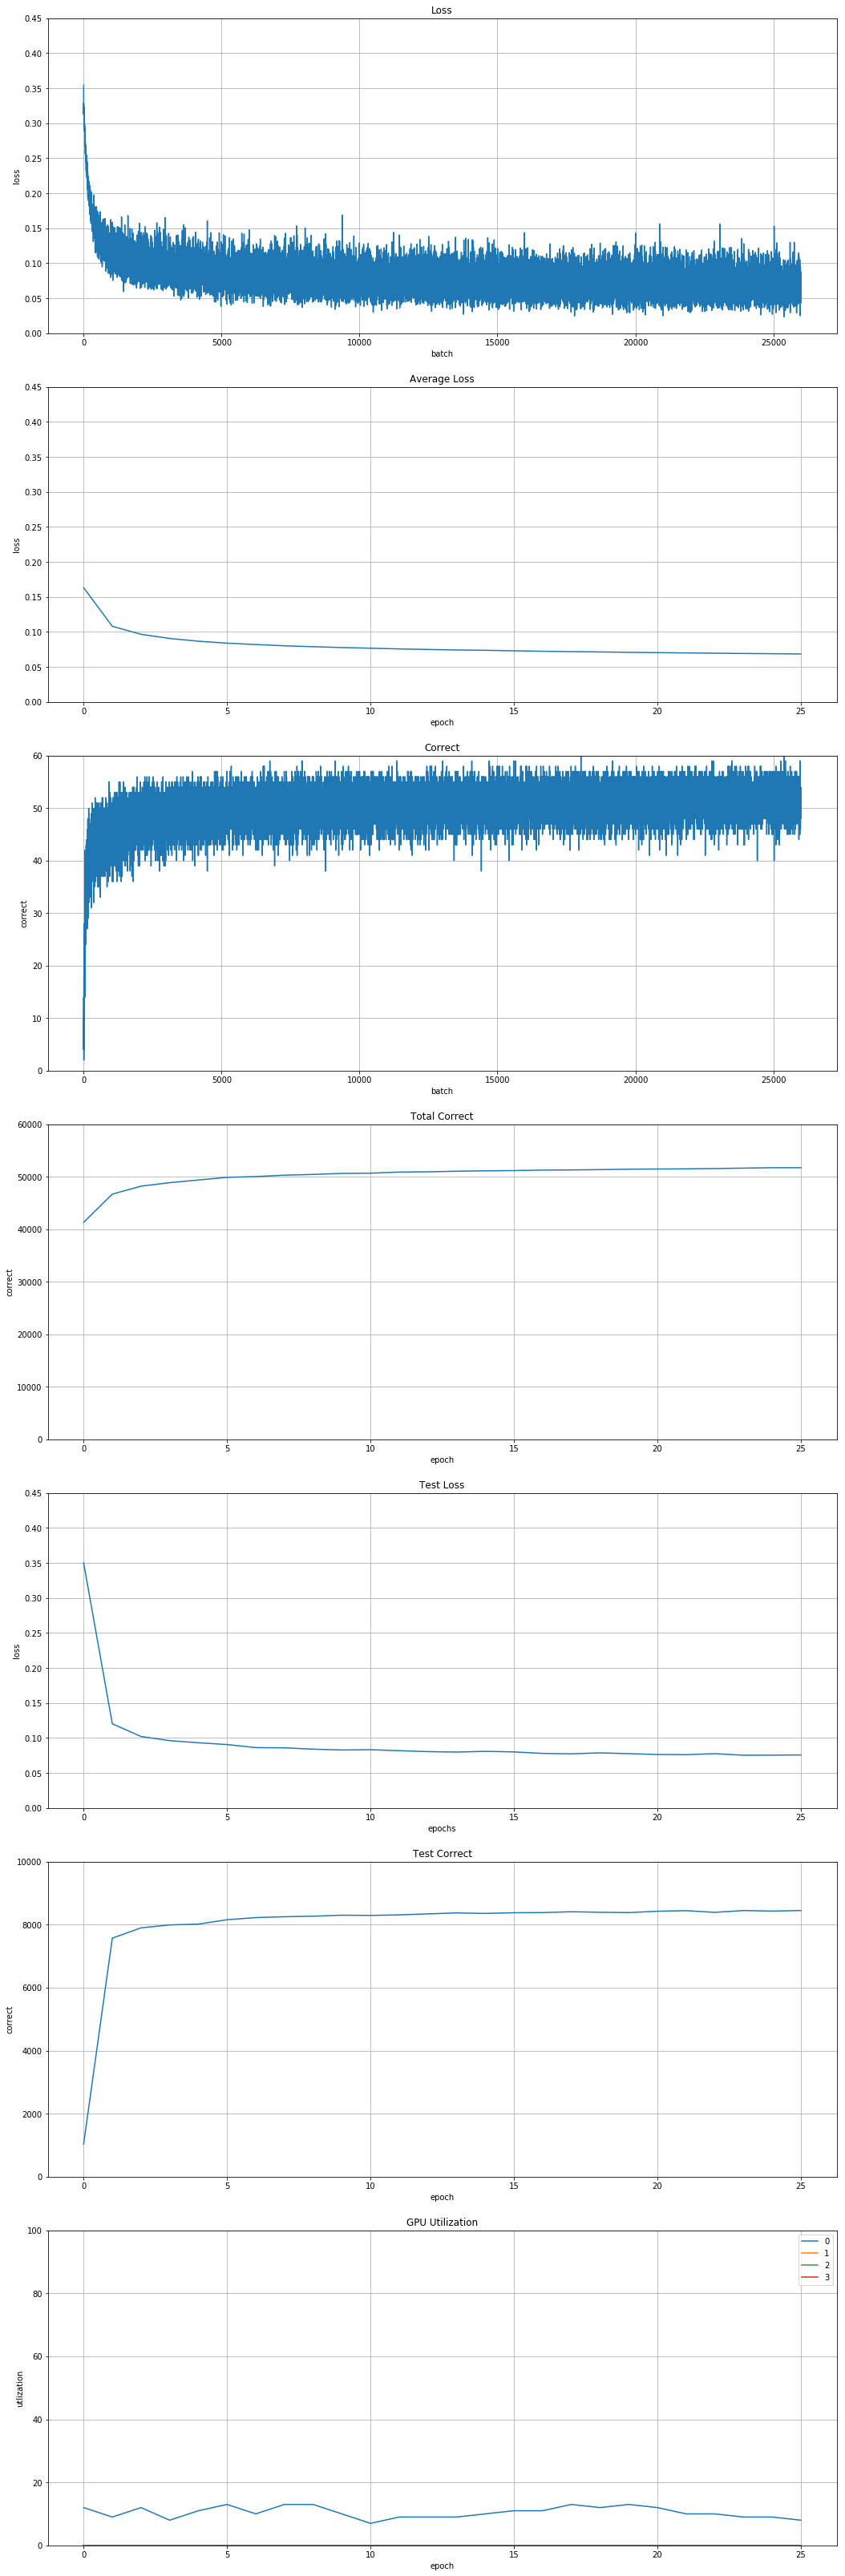

Confusion matrix of test data:
tf.Tensor(
[[840   0  16  44   8   5  72   0  15   0]
 [  5 954   6  26   6   0   1   0   2   0]
 [ 21   3 757  11 160   2  37   0   9   0]
 [ 29  12  23 863  44   1  23   0   5   0]
 [  0   0 105  30 815   2  40   0   8   0]
 [  0   0   0   1   0 938   0  38   4  19]
 [159   1 149  38 141   1 482   0  29   0]
 [  0   0   0   0   0  45   0 924   0  31]
 [  3   1  12   8   5   3  12   5 951   0]
 [  0   0   0   0   0  25   0  47   1 927]], shape=(10, 10), dtype=int32)

Total time: 138.5973527431488
Epochs/s: 0.18037862560283144
Updates/s: 180.37862560283142
Training Examples/Update: 60


In [12]:
show_results( PARAMETERS1, logs1 );

## Network 2:  Run-time 480s

In [13]:
# Epoch-wise learning
##########################################################################
# This updates the weights after a complete presentation of all training
# data.  It requires many epochs, but runs efficiently using the GPU
# to do lots in parallel.
##########################################################################
# Parameters

DTYPE = tf.float32;



PARAMETERS2 = {
    

    'WEIGHT_INIT' : vs_init,
    'BIAS_INIT' : zeros_init,
    
    'LEARNING_RATE' : 1.0,# made the learning rate higher than previous example


    'MAX_EPOCHS' : 1500,     # maximum number of epochs to run
    'TRAINING_SIZE' : x_train.shape[0], # number of training examples
    'TEST_SIZE' : x_test.shape[0], # number of testing examples


    # use this for mini-batch learning
    #'MINI_BATCH' : 1000,   # number of mini_batches per epoch

    # use this for iteration learning
    #'MINI_BATCH' : x_train.shape[0],

    # use this for epoch learning
    'MINI_BATCH' : 1,


};


##########################################################################
##########################################################################


    
# build the network
    
input_l  = InputLayer( PARAMETERS2, "input", 28*28 );
hidden_l = Layer( PARAMETERS2, "hidden", 28*28, sigmoid );
output_l = Layer( PARAMETERS2, "output", 10, softmax );

nn = input_l >> hidden_l >> output_l >> loss;

# train it

logs2 = nn.train_epochs( y_train, x_train, y_test, x_test );

Executing op __inference_loss_1355933 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_output_1355949 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_hot_1356010 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_preprocess_1356021 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_loss_1356121 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_output_1356137 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_un_hot_1356144 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_1358188 in device /job:localhost/replica:0/task:0/device:GPU:0
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,8

Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:GPU:0


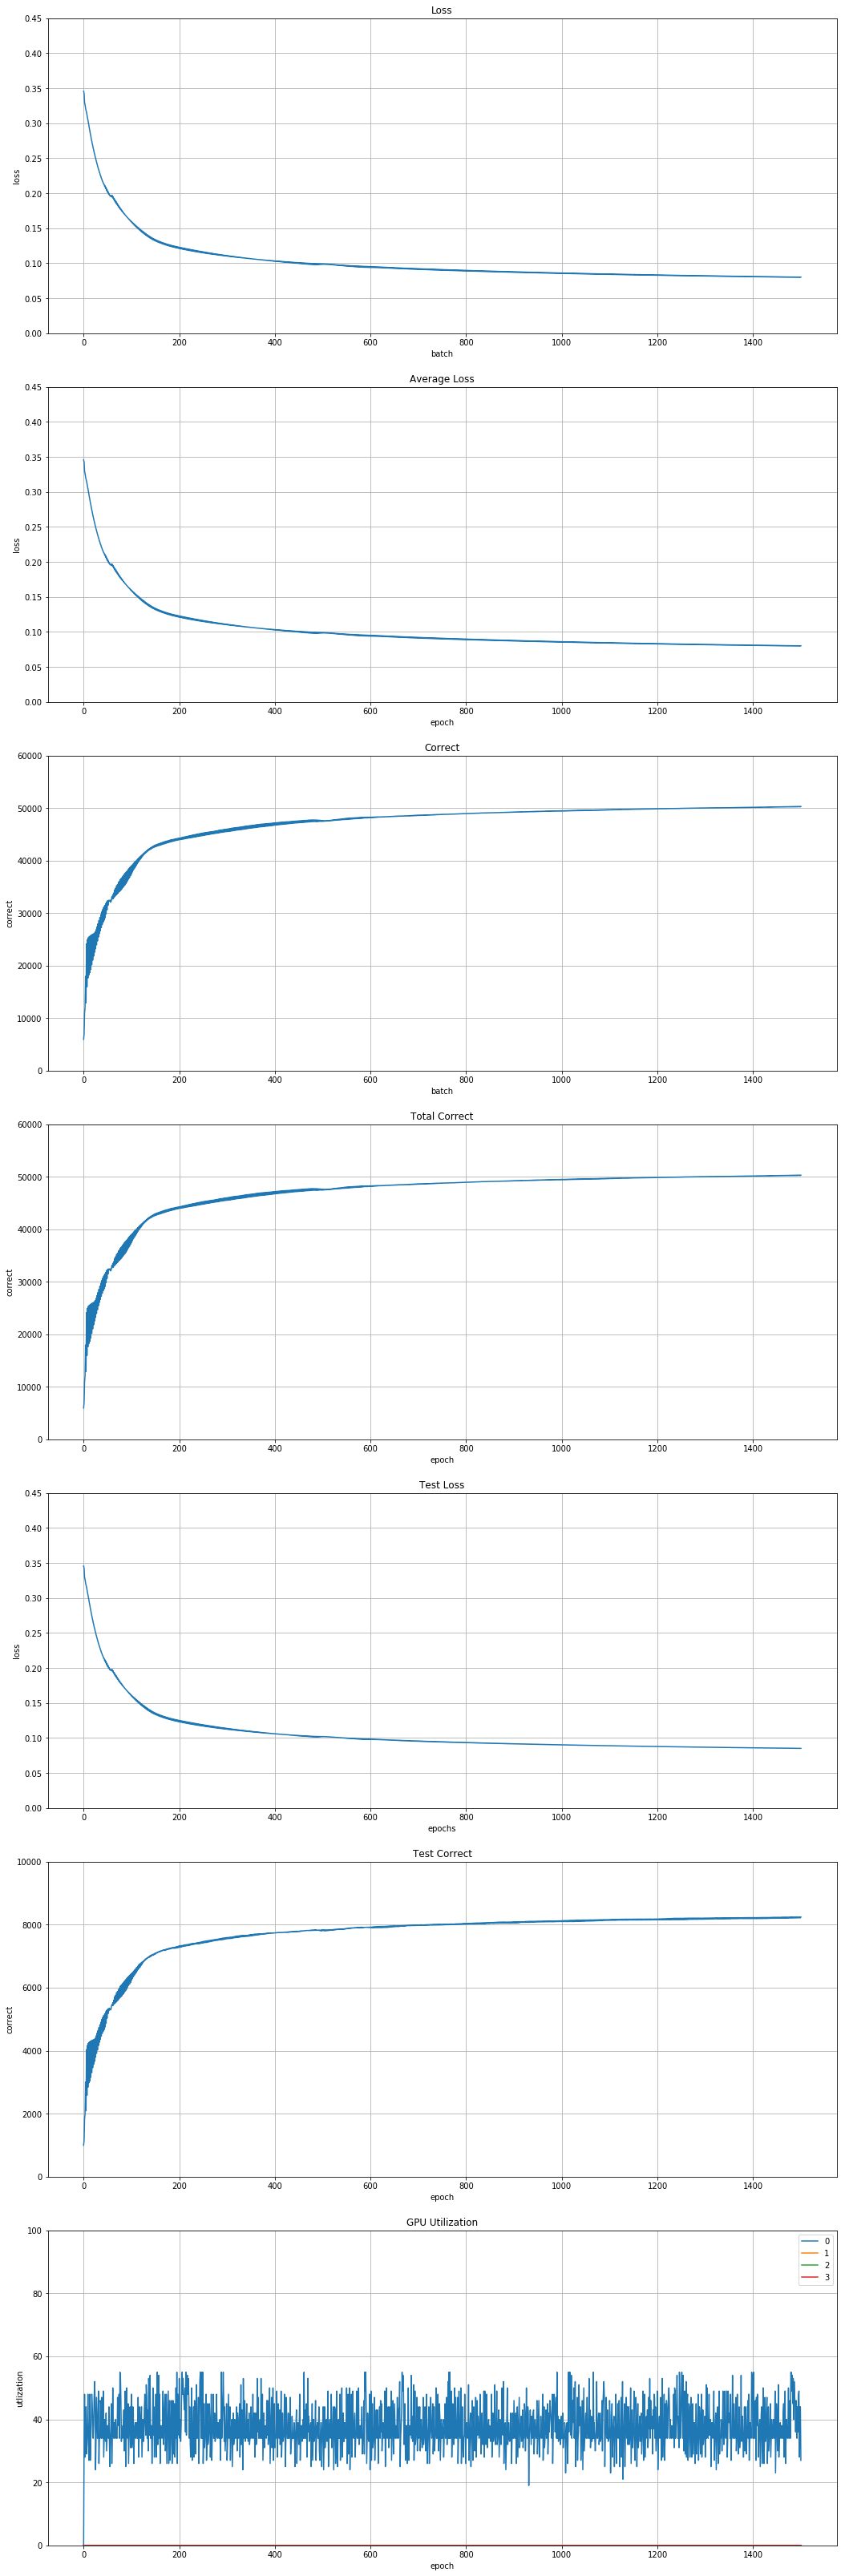

Confusion matrix of test data:
tf.Tensor(
[[844   4  22  52   6   4  49   0  19   0]
 [  5 943  12  32   6   0   0   0   2   0]
 [ 26   3 762  11 145   2  36   0  15   0]
 [ 40  11  18 861  38   1  26   0   5   0]
 [  3   3 127  39 770   2  50   0   6   0]
 [  0   0   0   2   0 896   0  61   5  36]
 [199   2 167  50 146   4 398   0  34   0]
 [  0   0   0   0   0  45   0 898   0  57]
 [  2   1  17  11   3   9  10   6 941   0]
 [  0   0   0   0   0  25   0  44   1 930]], shape=(10, 10), dtype=int32)

Total time: 435.6038091182709
Epochs/s: 3.4434960590363772
Updates/s: 3.4434960590363772
Training Examples/Update: 60000


In [14]:

show_results( PARAMETERS2, logs2 );





## Network 2:  Run-time 700s - not much output, be patient

In [15]:
# Element-wise learning
##########################################################################
# This updates the weights after each single example.
# It only trains for one epoch.
# Anticipated run time:  40s
##########################################################################
# Parameters

DTYPE = tf.float32;

  
PARAMETERS3 = {
    

    'WEIGHT_INIT' : vs_init,
    'BIAS_INIT' : zeros_init,
    
    'LEARNING_RATE' : 0.1,# made the learning rate very small


    'MAX_EPOCHS' : 1,     # maximum number of epochs to run
    'TRAINING_SIZE' : x_train.shape[0], # number of training examples
    'TEST_SIZE' : x_test.shape[0], # number of testing examples


    # use this for mini-batch learning
    #'MINI_BATCH' : 1000,   # number of mini_batches per epoch

    # use this for iteration learning
    'MINI_BATCH' : x_train.shape[0],

    # use this for epoch learning
    #'MINI_BATCH' : 1,


};



##########################################################################
##########################################################################


    
# build the network
    
input_l  = InputLayer( PARAMETERS3, "input", 28*28 );
hidden_l = Layer( PARAMETERS3, "hidden", 28*28, sigmoid );
output_l = Layer( PARAMETERS3, "output", 10, softmax );

nn = input_l >> hidden_l >> output_l >> loss;

# train it

logs3 = nn.train_epochs( y_train, x_train, y_test, x_test );

Executing op __inference_loss_1524813 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_output_1524829 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_hot_1524890 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_preprocess_1524901 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_loss_1525001 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_output_1525017 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_un_hot_1525024 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_1526988 in device /job:localhost/replica:0/task:0/device:GPU:0
0,1,


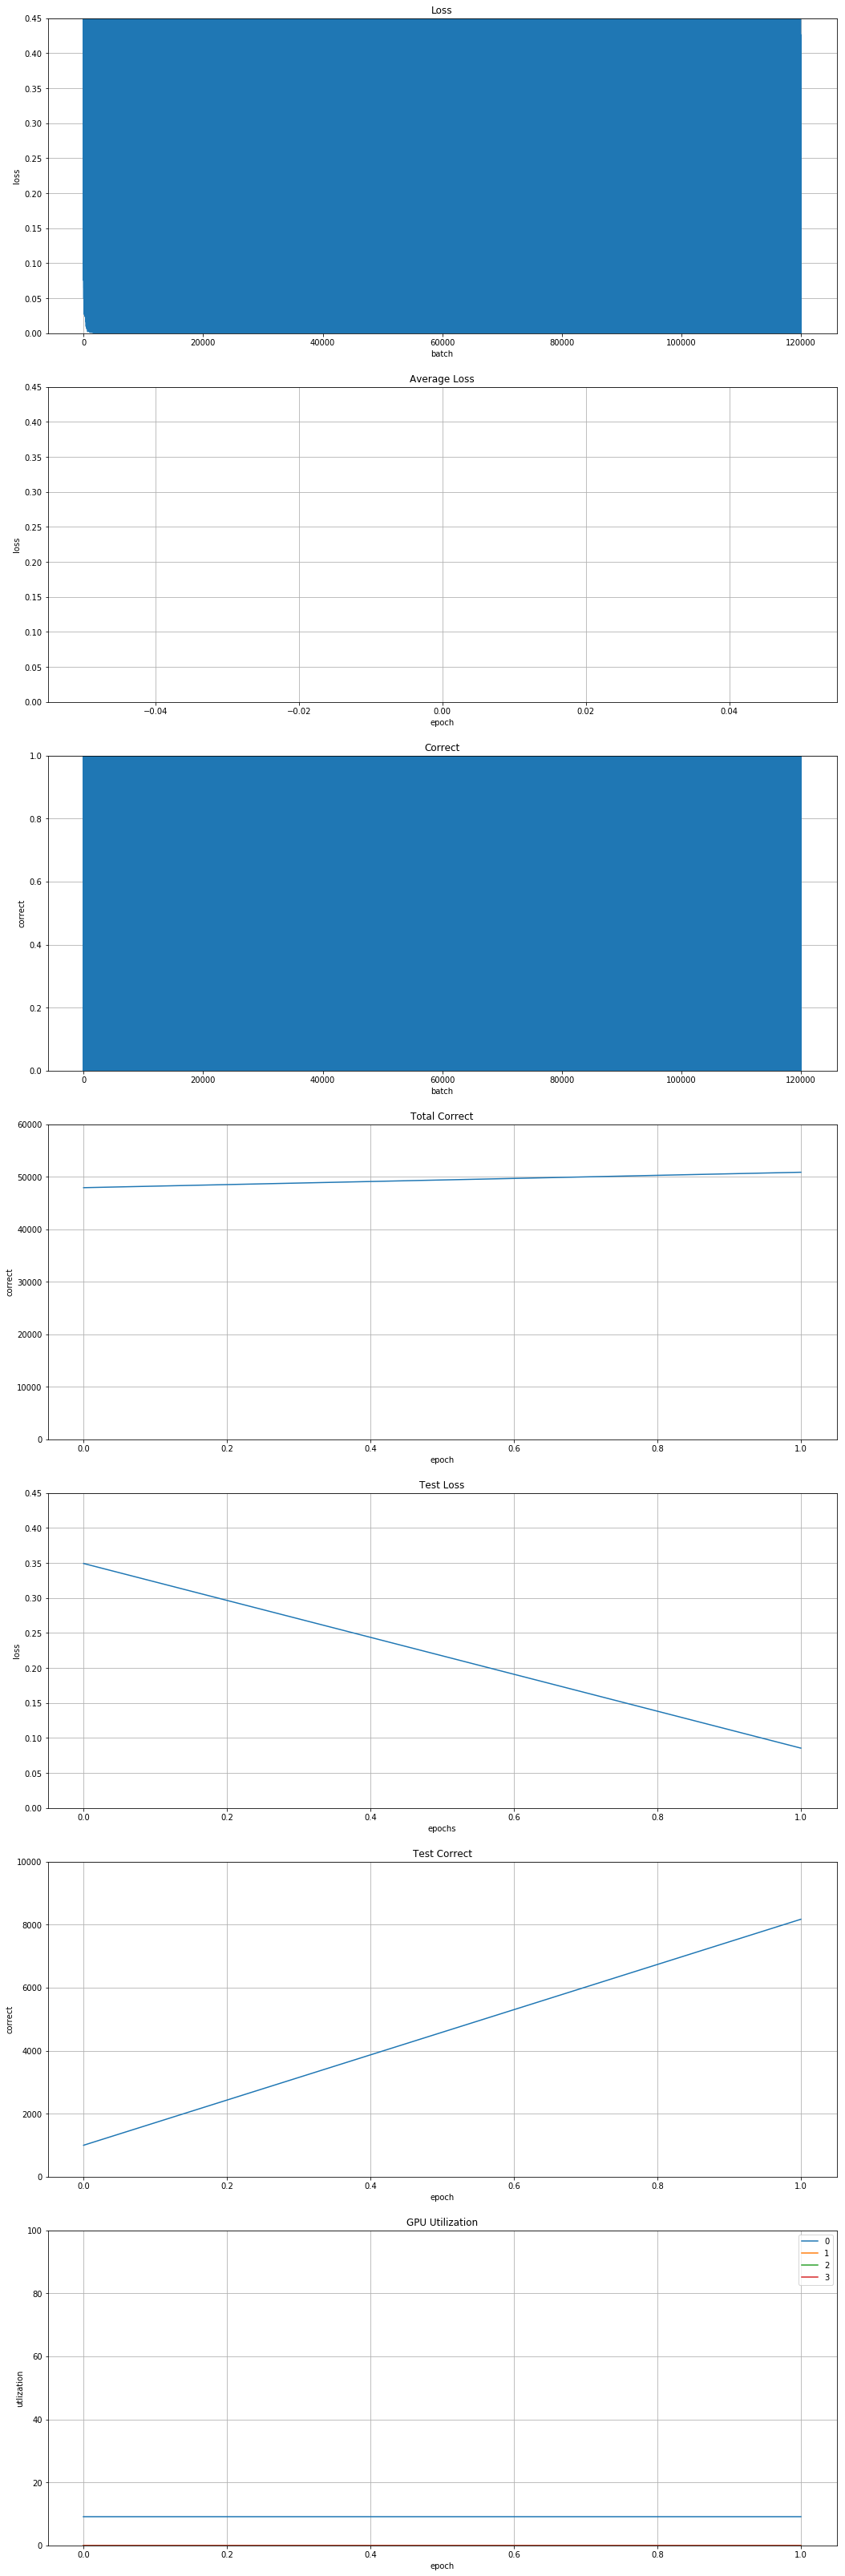

Confusion matrix of test data:
tf.Tensor(
[[732   0  10  35   0   0 211   0  12   0]
 [  6 945   8  28   3   0   6   2   2   0]
 [ 14   0 785   7  37   1 146   0  10   0]
 [ 46   8  14 847  12   0  67   0   6   0]
 [  6   1 214  46 470   0 254   0   9   0]
 [  1   0   0   2   0 889   0  68  11  29]
 [119   1 106  18  32   0 699   0  25   0]
 [  0   0   0   0   0  36   0 916   3  45]
 [  2   1   1   4   2   2  30   4 954   0]
 [  0   0   0   0   0  21   1  41   1 936]], shape=(10, 10), dtype=int32)

Total time: 697.9054267406464
Epochs/s: 0.001432858897043105
Updates/s: 85.9715338225863
Training Examples/Update: 1


In [16]:
show_results( PARAMETERS3, logs3 );

In [17]:
! date

Thu Jun 18 10:57:48 EDT 2020
